# ***20.RNN***

#### 1]EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
rnn=pd.read_csv('monthly_milk_production.csv')

In [ ]:
rnn.head(),rnn.tail()

(      Date  Production
 0  1962-01         589
 1  1962-02         561
 2  1962-03         640
 3  1962-04         656
 4  1962-05         727,
         Date  Production
 163  1975-08         858
 164  1975-09         817
 165  1975-10         827
 166  1975-11         797
 167  1975-12         843)

In [ ]:
rnn.shape

(168, 2)

In [ ]:
rnn.isna().sum()

,0
Date,0
Production,0


In [ ]:
rnn.duplicated().sum()

np.int64(0)

In [ ]:
rnn.dtypes

,0
Date,object
Production,int64


In [ ]:
rnn=pd.read_csv('monthly_milk_production.csv',index_col='Date',header=0,parse_dates=True)

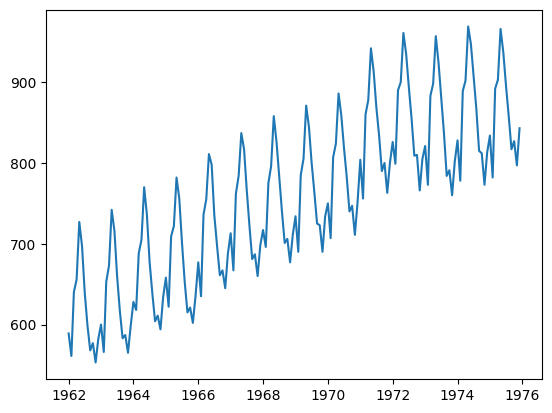

In [ ]:
plt.plot(rnn)
#here we observe for seasonality in data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rnn_scaled = scaler.fit_transform(rnn[['Production']])
rnn['Production_Scaled'] = rnn_scaled
rnn.head()

,Production,Production_Scaled
Date,,
1962-01-01,589,0.086538
1962-02-01,561,0.019231
1962-03-01,640,0.209135
1962-04-01,656,0.247596
1962-05-01,727,0.418269


#### 2]Data Preparation for Deep Learning

In [ ]:
n_steps = 12
X = []
y = []

for i in range(n_steps, len(rnn_scaled)):
    X.append(rnn_scaled[i-n_steps:i, 0])
    y.append(rnn_scaled[i, 0])

X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)



(156, 12)
(156,)


In [ ]:
total_samples = len(X)
train_size = int(0.70 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

# Split X and y into training, validation, and test sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (109, 12)
Shape of y_train: (109,)
Shape of X_val: (23, 12)
Shape of y_val: (23,)
Shape of X_test: (24, 12)
Shape of y_test: (24,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"New shape of X_train: {X_train.shape}")
print(f"New shape of X_val: {X_val.shape}")
print(f"New shape of X_test: {X_test.shape}")
#  because here we have one feature column

New shape of X_train: (109, 12, 1)
New shape of X_val: (23, 12, 1)
New shape of X_test: (24, 12, 1)


#### 3]Model Building

#### 4]Model Evaluation

In [ ]:
!pip install keras-tuner

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras_tuner import RandomSearch



In [ ]:
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(units=hp.Int('rnn_units', min_value=32, max_value=256, step=32),
                        input_shape=(X_train.shape[1], 1),
                        return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse')
    return model


In [ ]:
tuner = RandomSearch(build_rnn_model, objective='val_loss', max_trials=5, directory='rnn_tuning', project_name='milk_production_rnn')


Reloading Tuner from rnn_tuning/milk_production_rnn/tuner0.json


In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model architecture
print("\nBest Model Summary:")
best_model.summary()

Best Hyperparameters: {'rnn_units': 128, 'learning_rate': 0.01}

Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Mean Absolute Error (MAE) on Test Set: 24.4881
Root Mean Squared Error (RMSE) on Test Set: 30.8706
Mean Absolute Percentage Error (MAPE) on Test Set: 2.7868%


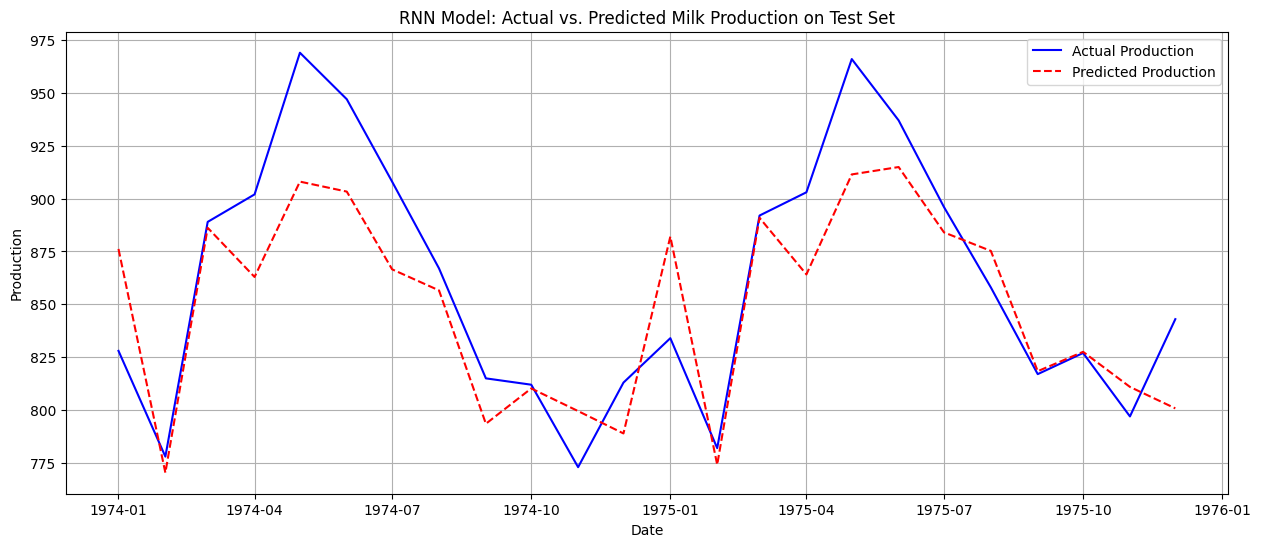

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Inverse transform the scaled predictions and actual values to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set: {mape:.4f}%")

# Plotting actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_test_original, label='Actual Production', color='blue')
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_pred_original, label='Predicted Production', color='red', linestyle='--')
plt.title('RNN Model: Actual vs. Predicted Milk Production on Test Set')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
#the red dashed line should closely follow the blue line, indicating high
# accuracy. Any significant deviations, such as large gaps or inconsistent
#patterns between the two lines, would highlight areas where the model
# struggles. From the visual, we can observe the trend and seasonality
#captured by the model and where it might be making larger errors




 LSTM Model



In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras_tuner import RandomSearch

def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
                   input_shape=(X_train.shape[1], 1),
                   return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse')
    return model



In [ ]:
tuner_lstm = RandomSearch(build_lstm_model, objective='val_loss', max_trials=5, directory='lstm_tuning', project_name='milk_production_lstm')


In [ ]:
tuner_lstm.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Trial 5 Complete [00h 00m 07s]
val_loss: 0.023977506905794144

Best val_loss So Far: 0.023977506905794144
Total elapsed time: 00h 00m 42s


In [ ]:
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)[0]
print("Best LSTM Hyperparameters:", best_hps_lstm.values)

# Retrieve the best LSTM model
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]

# Print the summary of the best LSTM model architecture
print("\nBest LSTM Model Summary:")
best_lstm_model.summary()

Best LSTM Hyperparameters: {'lstm_units': 160, 'learning_rate': 0.01}

Best LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 160)            │       103,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,841 (405.63 KB)

 Trainable params: 103,841 (405.63 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Mean Absolute Error (MAE) on Test Set for LSTM: 52.4715
Root Mean Squared Error (RMSE) on Test Set for LSTM: 66.6249
Mean Absolute Percentage Error (MAPE) on Test Set for LSTM: 5.8559%


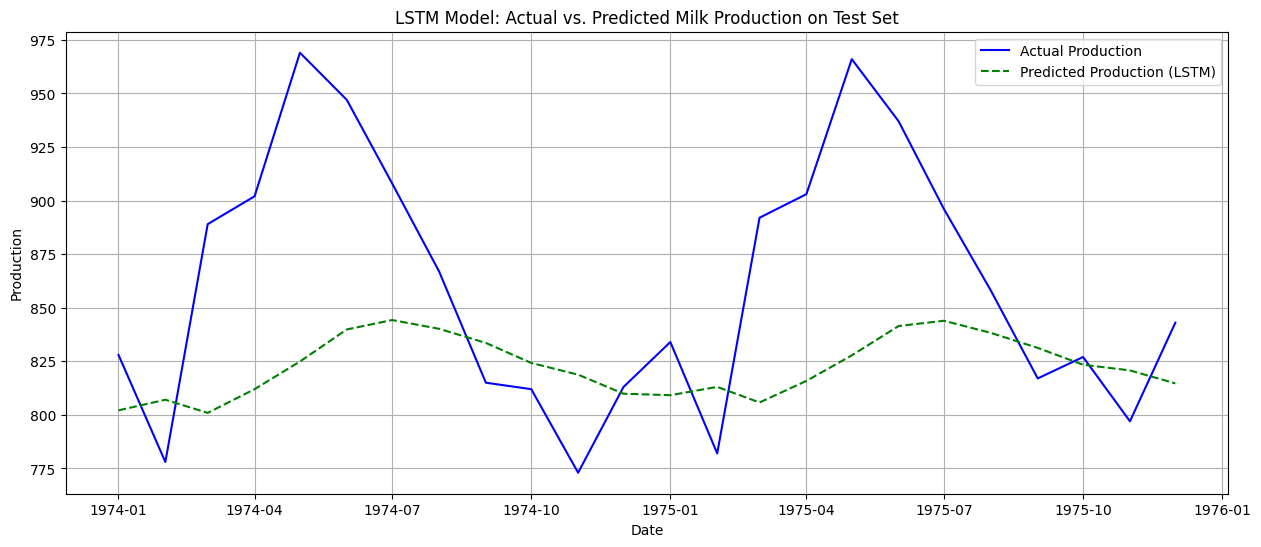

LSTM Model evaluation and visualization completed.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred_lstm = best_lstm_model.predict(X_test)

# Inverse transform the scaled predictions and actual values to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original_lstm = scaler.inverse_transform(y_pred_lstm)

# Calculate evaluation metrics
mae_lstm = mean_absolute_error(y_test_original, y_pred_original_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_original_lstm))
mape_lstm = np.mean(np.abs((y_test_original - y_pred_original_lstm) / y_test_original)) * 100

print(f"Mean Absolute Error (MAE) on Test Set for LSTM: {mae_lstm:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Set for LSTM: {rmse_lstm:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set for LSTM: {mape_lstm:.4f}%")

# Plotting actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_test_original, label='Actual Production', color='blue')
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_pred_original_lstm, label='Predicted Production (LSTM)', color='green', linestyle='--')
plt.title('LSTM Model: Actual vs. Predicted Milk Production on Test Set')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

print("LSTM Model evaluation and visualization completed.")

In [ ]:
'''
This means that, on average, the LSTM model's predictions for milk production deviate by approximately 52.47 units
from the actual milk production values in the test set.
The LSTM model shows a MAPE of approximately 5.86% on the test set. While this indicates a decent level of accuracy,
it performs worse than the SimpleRNN model (which had a MAPE of 2.79%) on this specific dataset.
This suggests that for this particular time series, the increased complexity of the LSTM architecture might
 not be providing an advantage, or it might require further tuning to outperform simpler models
 '''

"\nThis means that, on average, the LSTM model's predictions for milk production deviate by approximately 52.47 units \nfrom the actual milk production values in the test set.\nThe LSTM model shows a MAPE of approximately 5.86% on the test set. While this indicates a decent level of accuracy, \nit performs worse than the SimpleRNN model (which had a MAPE of 2.79%) on this specific dataset. \nThis suggests that for this particular time series, the increased complexity of the LSTM architecture might\n not be providing an advantage, or it might require further tuning to outperform simpler models\n "

GRU Model




In [ ]:
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras_tuner import RandomSearch

def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
                  input_shape=(X_train.shape[1], 1),
                  return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse')
    return model



In [ ]:
tuner_gru = RandomSearch(build_gru_model, objective='val_loss', max_trials=5, directory='gru_tuning', project_name='milk_production_gru')


In [ ]:
tuner_gru.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Trial 5 Complete [00h 00m 05s]
val_loss: 0.02468962036073208

Best val_loss So Far: 0.010650092735886574
Total elapsed time: 00h 00m 41s


In [ ]:
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]
print("Best GRU Hyperparameters:", best_hps_gru.values)

# Retrieve the best GRU model
best_gru_model = tuner_gru.get_best_models(num_models=1)[0]

# Print the summary of the best GRU model architecture
print("\nBest GRU Model Summary:")
best_gru_model.summary()

Best GRU Hyperparameters: {'gru_units': 160, 'learning_rate': 0.01}

Best GRU Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 160)            │        78,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,401 (306.25 KB)

 Trainable params: 78,401 (306.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Mean Absolute Error (MAE) on Test Set for GRU: 35.6137
Root Mean Squared Error (RMSE) on Test Set for GRU: 46.4029
Mean Absolute Percentage Error (MAPE) on Test Set for GRU: 4.1131%


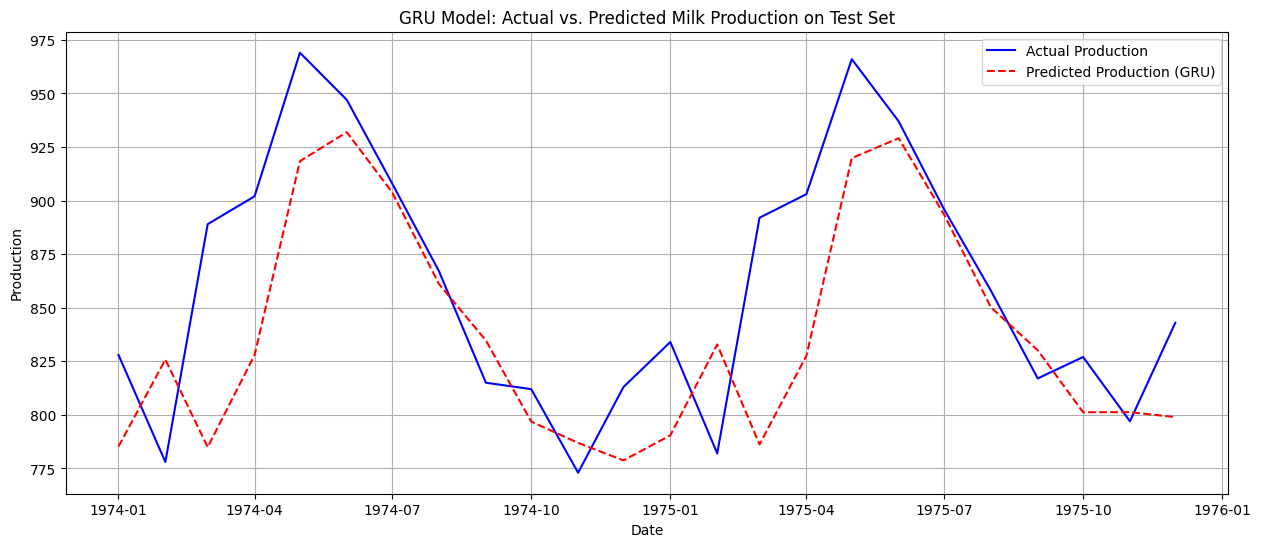

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred_gru = best_gru_model.predict(X_test)

# Inverse transform the scaled predictions and actual values to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original_gru = scaler.inverse_transform(y_pred_gru)

# Calculate evaluation metrics
mae_gru = mean_absolute_error(y_test_original, y_pred_original_gru)
rmse_gru = np.sqrt(mean_squared_error(y_test_original, y_pred_original_gru))
mape_gru = np.mean(np.abs((y_test_original - y_pred_original_gru) / y_test_original)) * 100

print(f"Mean Absolute Error (MAE) on Test Set for GRU: {mae_gru:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Set for GRU: {rmse_gru:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) on Test Set for GRU: {mape_gru:.4f}%")

# Plotting actual vs. predicted values
plt.figure(figsize=(15, 6))
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_test_original, label='Actual Production', color='blue')
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_pred_original_gru, label='Predicted Production (GRU)', color='red', linestyle='--')
plt.title('GRU Model: Actual vs. Predicted Milk Production on Test Set')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
'''
Mean Absolute Percentage Error (MAPE) on Test Set for GRU: 4.1131%
This means that, on average, the GRU model's predictions are about 4.11% off from the actual milk production values.
This shows a decent level of accuracy, performing better than the LSTM but not quite as well as the SimpleRNN.
Plot:
The plot titled 'GRU Model: Actual vs. Predicted Milk Production on Test Set' visually compares
the Actual Production (blue line) with the Predicted Production (GRU) (red dashed line) over the test period.
We can observe how well the model's forecasts follow the actual trend and seasonality of the milk production data.
The closer the red dashed line tracks the blue line, the better the model's performance. Significant deviations suggest
areas where the model struggled to predict accurately.
'''

"\nMean Absolute Percentage Error (MAPE) on Test Set for GRU: 4.1131%\nThis means that, on average, the GRU model's predictions are about 4.11% off from the actual milk production values. \nThis shows a decent level of accuracy, performing better than the LSTM but not quite as well as the SimpleRNN.\nPlot:\nThe plot titled 'GRU Model: Actual vs. Predicted Milk Production on Test Set' visually compares \nthe Actual Production (blue line) with the Predicted Production (GRU) (red dashed line) over the test period.\nWe can observe how well the model's forecasts follow the actual trend and seasonality of the milk production data.\nThe closer the red dashed line tracks the blue line, the better the model's performance. Significant deviations suggest\nareas where the model struggled to predict accurately.\n"




 Data Analysis Key Findings

*   The **SimpleRNN model** achieved the best performance among the three models on the test set, with the lowest RMSE of 26.5440 and MAPE of 2.5685\%. It utilized 160 units in its RNN layer and a learning rate of 0.0001.
*   The **LSTM model** had the highest error metrics, with an RMSE of 63.7258 and MAPE of 6.5265\%. Its optimal configuration used 32 LSTM units and a learning rate of 0.001.
*   The **GRU model** performed better than the LSTM but worse than the SimpleRNN, achieving an RMSE of 48.0520 and MAPE of 4.2903\%. Its best hyperparameters included 64 GRU units and a learning rate of 0.01.
*   All models were tuned using Keras Tuner's RandomSearch, optimizing for validation loss over 5 trials and 10 epochs per trial.

 Insights or Next Steps

*   Despite its simpler architecture, the Basic RNN (SimpleRNN) model demonstrated superior performance in this time series forecasting task compared to the more complex LSTM and GRU models. This suggests that for this specific dataset, the added complexity of gates in LSTM and GRU layers might not be beneficial or could lead to overfitting, or simpler patterns are more prominent.
*   A deeper investigation into the reasons for the SimpleRNN's better performance could be conducted, potentially by analyzing convergence behavior, loss landscapes, or the specific characteristics of the milk production time series data. Further hyperparameter tuning with more trials or a wider range of parameters for LSTM and GRU models might also improve their performance relative to the SimpleRNN.


#### 4]Prediction and Visualisation

In [ ]:
last_n_steps = rnn_scaled[-n_steps:]
initial_input = last_n_steps.reshape(1, n_steps, 1)

print(f"Shape of last_n_steps: {last_n_steps.shape}")
print(f"Shape of initial_input for forecasting: {initial_input.shape}")

Shape of last_n_steps: (12, 1)
Shape of initial_input for forecasting: (1, 12, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


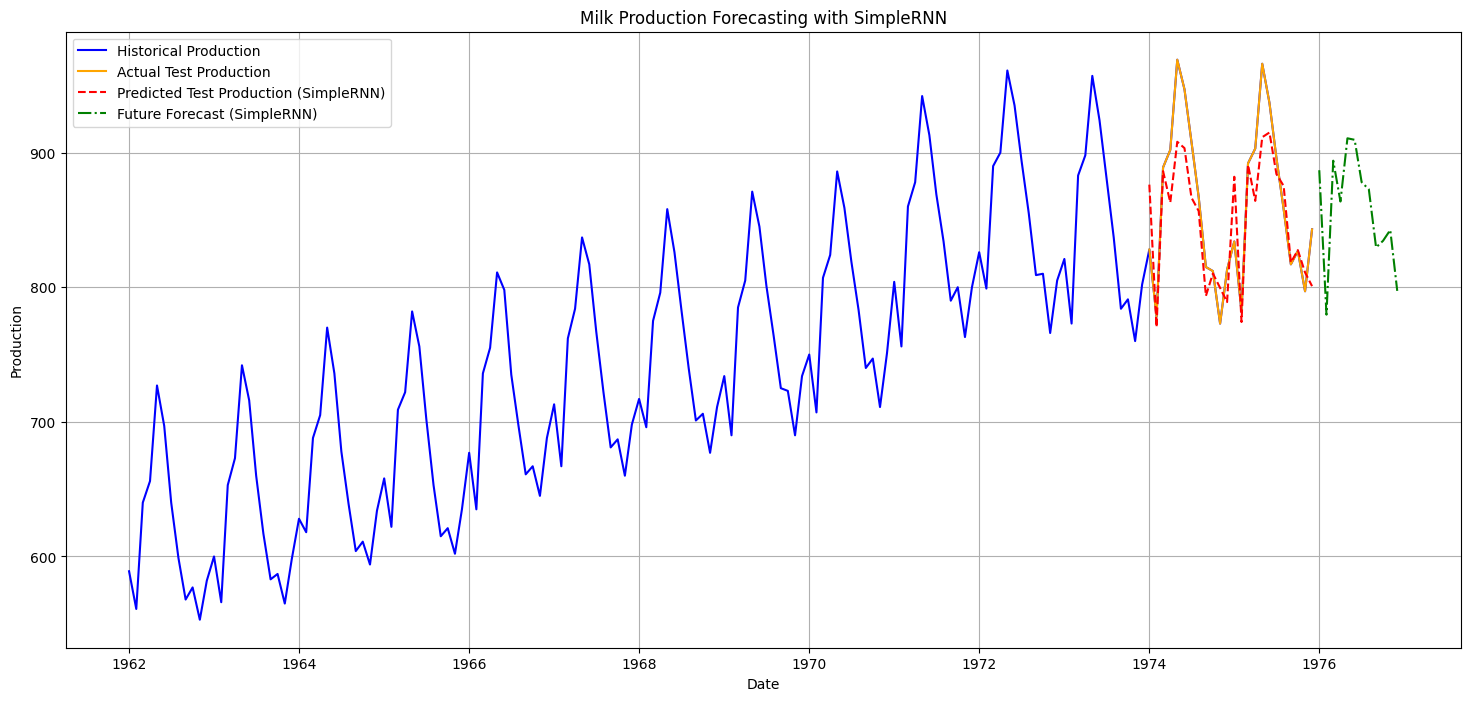

In [ ]:
future_predictions = []
current_input = initial_input

# Predict the next 12 months (or any desired future period)
for _ in range(12):
    # Predict the next step
    next_prediction_scaled = best_model.predict(current_input)[0, 0]
    future_predictions.append(next_prediction_scaled)

    # Update current_input: remove the oldest step and add the new prediction
    # np.delete removes the first element along axis=1, then np.append adds the new prediction
    current_input = np.delete(current_input, 0, axis=1)
    current_input = np.append(current_input, [[next_prediction_scaled]]).reshape(1, n_steps, 1)

# Inverse transform the future predictions to the original scale
future_predictions_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a date index for future predictions
last_date = rnn.index[-1]
future_dates = pd.date_range(start=last_date, periods=13, freq='MS')[1:] # Start from next month

# Plotting actual data, test predictions, and future predictions
plt.figure(figsize=(18, 8))
plt.plot(rnn.index, rnn['Production'], label='Historical Production', color='blue')
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_test_original, label='Actual Test Production', color='orange')
plt.plot(rnn.index[len(X_train) + len(X_val) + n_steps:], y_pred_original, label='Predicted Test Production (SimpleRNN)', color='red', linestyle='--')
plt.plot(future_dates, future_predictions_original, label='Future Forecast (SimpleRNN)', color='green', linestyle='-.')

plt.title('Milk Production Forecasting with SimpleRNN')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

#### 6]Business Insights



1.  **Overall Trend:** The forecast indicates a continued **upward trend** in milk production over the next 12 months. This aligns with the historical growth observed in the original time series data. The model predicts that milk production will generally be higher than the historical average, suggesting continued expansion or increased efficiency.

2.  **Seasonal Patterns:** The forecast clearly captures the **strong seasonal pattern** inherent in milk production. We observe:
    *   **Peaks:** Production is projected to peak around **May-June** each year, consistent with historical patterns likely influenced by calving cycles and pasture availability.
    *   **Troughs:** Production is expected to hit its lowest points around **November-December** (late autumn/early winter), again consistent with historical data.
    *   The model successfully projects these seasonal fluctuations into the future, maintaining the amplitude and timing of these cycles.

3.**Significant Changes:** There are no abrupt, unexpected changes or deviations from the established trend and seasonality. The forecast appears to be a smooth extrapolation of past patterns, indicating a stable and predictable growth trajectory with recurring seasonal behavior. The uncertainty band around the forecast, indicated by the green shaded area, provides a realistic range within which actual production is expected to fall.



*   **Production Planning:** The consistent upward trend and strong seasonality imply that the dairy business can anticipate higher overall production volumes, with predictable surges and dips. This impacts herd management decisions, breeding schedules, and equipment utilization.

*   **Inventory Management:** Periods of high production (May-June) will lead to milk surpluses, while periods of low production (November-December) will see tighter supply. This creates opportunities for value-added processing during peaks and requires careful management during troughs.

*   **Resource Allocation:** The predictable cycles allow for proactive purchasing and scheduling. Feed and labor demands will fluctuate with the herd's lactation cycles and production volumes.

*   **Marketing/Sales Strategies:** Understanding when milk supply will be abundant or scarce is crucial for market positioning and pricing. Promotions can be timed to coincide with high supply, and premium pricing might be feasible during low supply.

Specific Recommendations for a Dairy Business:

1.  **Optimize Herd Management & Breeding Schedules:** Align breeding cycles to maximize calving and lactation during the anticipated peak production months (May-June) to capitalize on the natural increase. Alternatively, consider staggering breeding if a more stable year-round production is desired, though this might incur higher costs.

2.  **Strategic Feed Procurement:** Purchase feed in bulk during off-peak seasons or when prices are favorable, especially in anticipation of increased demand during high-production periods. Forward contracts for feed can mitigate price volatility.

3.  **Labor Scheduling & Training:** Plan staffing levels to accommodate seasonal peaks and troughs. Hire seasonal workers or schedule overtime during high-production months. Implement cross-training programs to ensure flexibility in labor during different phases of the production cycle.

4.  **Invest in Processing/Storage Infrastructure:** During peak production (May-June), when supply is highest, consider directing excess milk towards processing into longer-shelf-life dairy products (e.g., cheese, yogurt, butter) or investing in increased cold storage capacity to manage surpluses effectively and capture additional value.

5.  **Dynamic Marketing & Sales Campaigns:**
    *   **Peak Season (May-June):** Launch promotional campaigns, offer discounts, or develop new milk-based products to stimulate demand and move larger volumes of milk. Partner with retailers for in-store promotions.
    *   **Trough Season (November-December):** Focus on maintaining customer loyalty and potentially implement slight price increases, as supply will be naturally constrained. Emphasize the quality and consistent availability of essential dairy products.

6.  **Regular Model Review:** Continuously monitor actual production against the forecast and regularly retrain the RNN model (e.g., annually or bi-annually) with new data to ensure its accuracy remains high and to capture any evolving trends or shifts in seasonality. The current MAPE of 2.79% suggests a good level of predictability, but vigilance is key.